# U-Net Fine-Tuning for Image Classification on Modified Mini-GCD Dataset with Classification Head

### 0. Setup Environment

#### 0.1. Install Required Libraries

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import segmentation_models_pytorch as smp
from torch.optim.lr_scheduler import ReduceLROnPlateau

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch.nn.functional as F
from torchvision.utils import make_grid


#### 0.2. Check GPU Availability

In [2]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.get_device_name())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

True
1
0
NVIDIA GeForce GTX 1080 Ti
cuda


In [3]:
# Hyperparameters
num_epochs = 50

#### 1. Define Dataset and Transformations

In [15]:
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

data_dir = "modified-mini-GCD"
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")

train_dataset = ImageFolder(root=train_dir, transform=transform_train)
val_dataset = ImageFolder(root=test_dir, transform=transform_val)
test_dataset = ImageFolder(root=test_dir, transform=transform_val)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)

### 2. Load the pre-trained U-Net model

#### 2.1. Load the Pre-trained U-Net Model and Print the Number of Trainable Parameters

In [5]:
# 2. Load the pre-trained U-Net model
unet = smp.Unet(encoder_name="resnet34", encoder_weights="imagenet", classes=1, activation=None)

# Print the number of trainable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'Number of trainable parameters in U-Net: {count_parameters(unet)}')

Number of trainable parameters in U-Net: 24436369


#### 2.2. Add a Classification Head to the U-Net

In [6]:
class UNetClassifier(nn.Module):
    def __init__(self, unet, num_classes):
        super(UNetClassifier, self).__init__()
        self.unet = unet
        # Get the number of output channels from the final layer of the U-Net
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.BatchNorm1d(unet.segmentation_head[0].out_channels),
            nn.Dropout(0.5),
            nn.Linear(unet.segmentation_head[0].out_channels, num_classes)
        )

    def forward(self, x):
        features = self.unet(x)
        out = self.classifier(features)
        return out

num_classes = len(train_dataset.classes)
# Initialize and move model to device (GPU or CPU)
classifier = UNetClassifier(unet, num_classes).to(device)

### 3. Prepare for Training

#### 3.1. Define Loss Function and Optimizer

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

C:\Users\Stefan\Documents\GitHub\UBB-Y3-AI-Research\DiffusionClassifier_initial\.venv\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


#### 3.2. Train the Classifier

In [8]:
# Training and validation loop
num_epochs = 100
train_losses = []
val_losses = []
best_train_loss = float('inf')
patience = 20
patience_counter = 0

for epoch in range(num_epochs):
    classifier.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = classifier(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(classifier.parameters(), max_norm=1.0)
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation loop
    classifier.eval()
    val_running_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = classifier(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() * inputs.size(0)

    val_loss = val_running_loss / len(val_loader.dataset)
    val_losses.append(val_loss)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    # Update learning rate
    scheduler.step(val_loss)

    # Early stopping
    if train_loss < best_train_loss:
        best_train_loss = val_loss
        patience_counter = 0
        # Save the best model
        torch.save(classifier.state_dict(), 'unet_classifier.pth')
    # else:
    #     patience_counter += 1
    #     if patience_counter >= patience:
    #         print("Early stopping")
    #         break

Epoch 1/100, Train Loss: 0.5711, Val Loss: 0.8668
Epoch 2/100, Train Loss: 0.5537, Val Loss: 4.8382
Epoch 3/100, Train Loss: 0.5579, Val Loss: 2.5927
Epoch 4/100, Train Loss: 0.5347, Val Loss: 0.7155
Epoch 5/100, Train Loss: 0.4878, Val Loss: 0.6929
Epoch 6/100, Train Loss: 0.5170, Val Loss: 0.6344
Epoch 7/100, Train Loss: 0.4810, Val Loss: 0.6443
Epoch 8/100, Train Loss: 0.4933, Val Loss: 0.6691
Epoch 9/100, Train Loss: 0.4831, Val Loss: 0.5532
Epoch 10/100, Train Loss: 0.4678, Val Loss: 0.6932
Epoch 11/100, Train Loss: 0.5126, Val Loss: 0.7021
Epoch 12/100, Train Loss: 0.4753, Val Loss: 0.6588
Epoch 13/100, Train Loss: 0.4275, Val Loss: 0.6232
Epoch 14/100, Train Loss: 0.4471, Val Loss: 0.6115
Epoch 15/100, Train Loss: 0.4657, Val Loss: 0.6104
Epoch 16/100, Train Loss: 0.4348, Val Loss: 0.6108
Epoch 17/100, Train Loss: 0.4351, Val Loss: 0.6003
Epoch 18/100, Train Loss: 0.4083, Val Loss: 0.5885
Epoch 19/100, Train Loss: 0.4789, Val Loss: 0.6101
Epoch 20/100, Train Loss: 0.3984, Val Lo

#### 3.3. Plot Training and Validation Losses

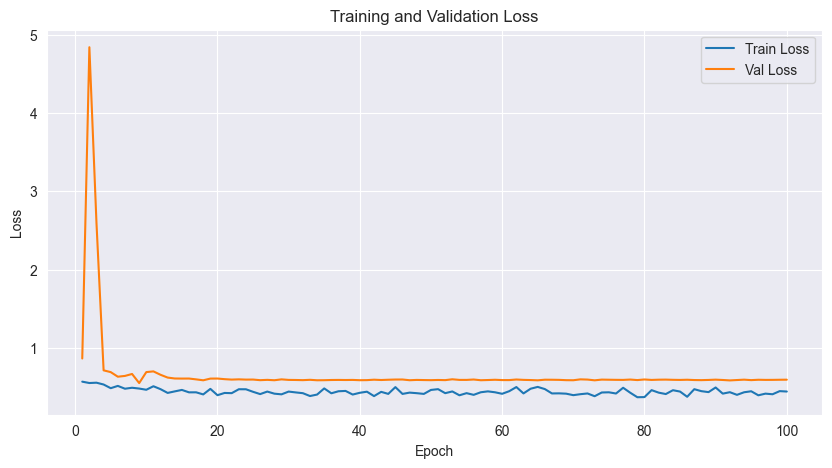

In [9]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

### 4. Persist the Model

In [10]:
# Save the model
def save_model(model, path):
    torch.save(model.state_dict(), path)

# Load the model
def load_model(model, path):
    model.load_state_dict(torch.load(path))
    model.eval()

# Save the trained model
# save_model(model, 'unet_classifier.pth')

# Load the model back
loaded_model = UNetClassifier(unet, num_classes)
load_model(loaded_model, 'unet_classifier.pth')

# Move the loaded model to the device
loaded_model.to(device)

C:\Users\Stefan\AppData\Local\Temp\ipykernel_31532\3378097738.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))


UNetClassifier(
  (unet): Unet(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): B

### 5. Evaluate the model

Accuracy: 0.7500
Precision: 0.7500
Recall: 0.7500
F1 Score: 0.7470
              precision    recall  f1-score   support

  1_clearsky       0.75      0.83      0.79        18
    2_cloudy       0.75      0.64      0.69        14

    accuracy                           0.75        32
   macro avg       0.75      0.74      0.74        32
weighted avg       0.75      0.75      0.75        32



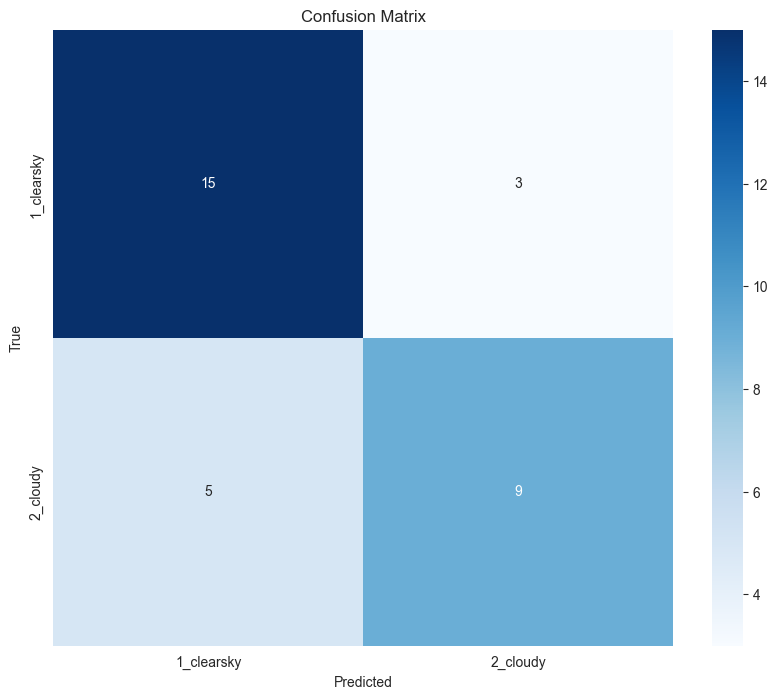

In [16]:
def evaluate_model(model, test_loader, device):
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # Convert lists to numpy arrays
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)

    # Print evaluation metrics
    print(f'Accuracy: {accuracy_score(all_labels, all_preds):.4f}')
    print(f'Precision: {precision_score(all_labels, all_preds, average="weighted"):.4f}')
    print(f'Recall: {recall_score(all_labels, all_preds, average="weighted"):.4f}')
    print(f'F1 Score: {f1_score(all_labels, all_preds, average="weighted"):.4f}')

    # Print classification report
    print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))

    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Evaluate the loaded model
evaluate_model(classifier, test_loader, device)

### 6. Visualize the Model Predictions

torch.Size([16, 3, 256, 256]) torch.Size([16])


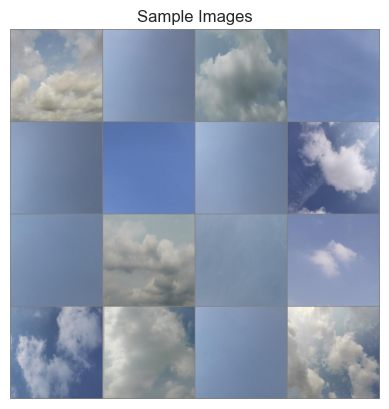

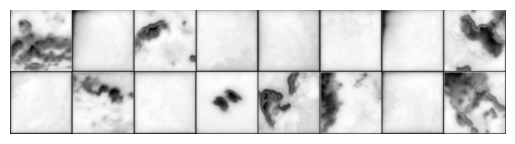

Ground Truth Labels: [1 0 1 0 0 0 0 1 0 1 0 1 1 1 0 1]
Predicted Labels: [1 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1]
Accuracy: 0.8125
Precision: 0.8636
Recall: 0.8125
F1 Score: 0.8057
              precision    recall  f1-score   support

  1_clearsky       0.73      1.00      0.84         8
    2_cloudy       1.00      0.62      0.77         8

    accuracy                           0.81        16
   macro avg       0.86      0.81      0.81        16
weighted avg       0.86      0.81      0.81        16



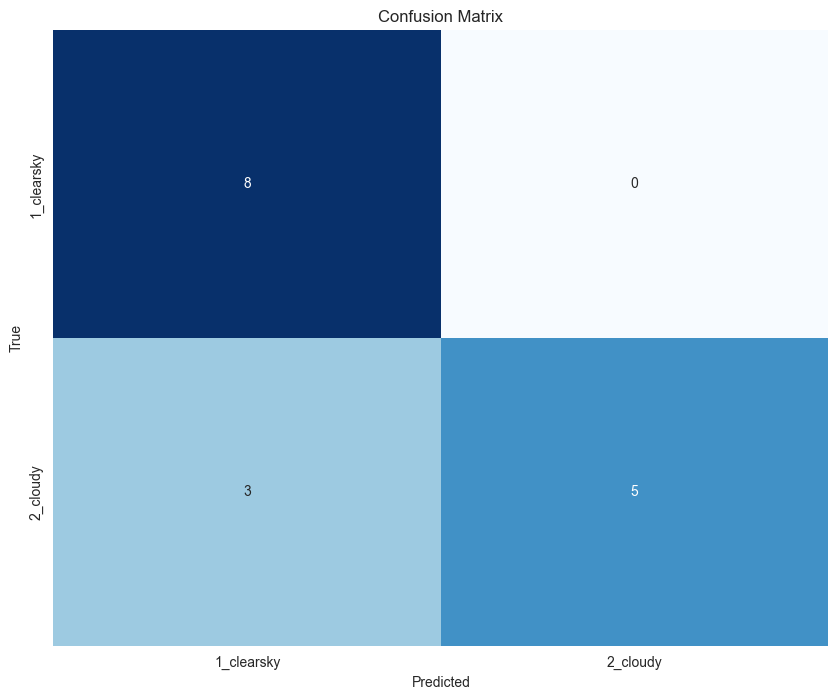

In [23]:
num_batches = 2
batch_size = 8

# Function to visualize images
def imshow(img, title=None):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')  # Remove axis numbers
    if title is not None:
        plt.title(title)
    plt.show()

# Function to visualize feature maps
def visualize_feature_maps(feature_maps):
    feature_maps = feature_maps.detach().cpu()
    grid_img = make_grid(feature_maps, normalize=True, scale_each=True, nrow=8)
    plt.imshow(np.transpose(grid_img, (1, 2, 0)))
    plt.axis('off')  # Remove axis numbers
    plt.show()

# Select a few sample images from the test dataset
def get_sample_images(test_loader, num_batches=2):
    sample_images = []
    sample_labels = []
    for images, labels in test_loader:
        sample_images.append(images)
        sample_labels.append(labels)
        if len(sample_images) >= num_batches:
            break
    return torch.cat(sample_images), torch.cat(sample_labels)

# Get sample images and labels
sample_images, sample_labels = get_sample_images(test_loader, num_batches=num_batches)
print(sample_images.shape, sample_labels.shape)

# Visualize the original images
imshow(make_grid(sample_images, nrow=4), title="Sample Images")

# Pass the images through the model and visualize the intermediate feature maps
def forward_pass_with_feature_maps(model, images, device):
    images = images.to(device)
    model.eval()
    with torch.no_grad():
        features = model.unet(images)
        outputs = model.classifier(features)
    return features, outputs

# Get feature maps and outputs
features, outputs = forward_pass_with_feature_maps(loaded_model, sample_images, device)

# Resize feature maps to match the size of the original images
features_resized = F.interpolate(features, size=(256, 256), mode='bilinear', align_corners=False)

# Visualize the feature maps
visualize_feature_maps(features_resized)

# Get the predicted labels
_, predicted = torch.max(outputs, 1)
predicted = predicted.cpu().numpy()

# Print the ground truth and predicted labels
print("Ground Truth Labels:", sample_labels.cpu().numpy())
print("Predicted Labels:", predicted)

# Print evaluation metrics for the sampled images
accuracy = accuracy_score(sample_labels.cpu().numpy(), predicted)
precision = precision_score(sample_labels.cpu().numpy(), predicted, average="weighted")
recall = recall_score(sample_labels.cpu().numpy(), predicted, average="weighted")
f1 = f1_score(sample_labels.cpu().numpy(), predicted, average="weighted")

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# Print classification report
print(classification_report(sample_labels.cpu().numpy(), predicted, target_names=train_dataset.classes))

# Plot confusion matrix
cm = confusion_matrix(sample_labels.cpu().numpy(), predicted)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes, cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

num_samples = num_batches * batch_size

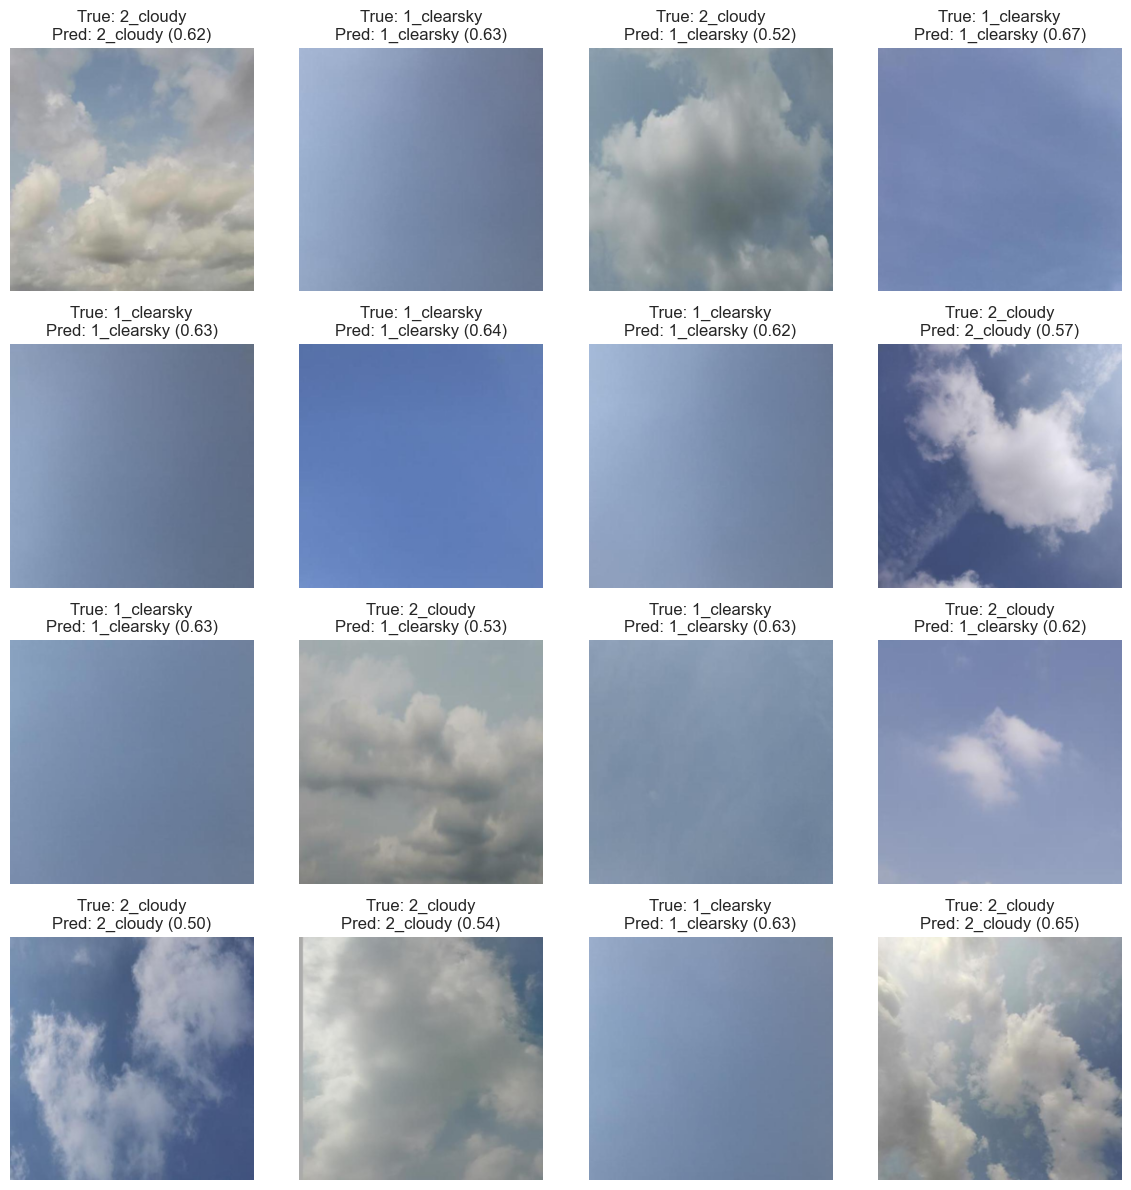

In [27]:

# Display the sample images with true and predicted labels
# Flatten the sampled images
sample_images = sample_images.view(num_samples, 3, 256, 256)
num_cols = 4
num_rows = (sample_images.size(0) + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 3 * num_rows))
axes = axes.flatten()

for i in range(sample_images.size(0)):
    image = sample_images[i].cpu()
    image = (image * 0.5 + 0.5)  # Unnormalize
    image = np.clip(image, 0, 1)
    true_label = sample_labels[i].item()
    pred_label = predicted[i]
    prob = torch.softmax(outputs[i], dim=0)[pred_label].item()  # Probability of predicted class
    axes[i].imshow(image.permute(1, 2, 0))  # Convert CHW to HWC for plotting
    axes[i].axis("off")
    axes[i].set_title(
        f"True: {train_dataset.classes[true_label]}\n"
        f"Pred: {train_dataset.classes[pred_label]} ({prob:.2f})"
    )

# Hide any remaining empty subplots
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.subplots_adjust(wspace=0.1, hspace=0.3)
plt.tight_layout()
plt.show()